# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os
from sklearn.utils import shuffle
import cnn_helper

#%%

# TODO: fill this in based on where you saved the training and testing data
training_file = 'dataset/train.p'
testing_file =  'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)


X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


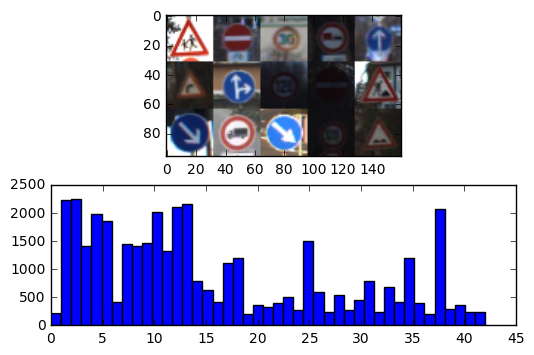

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

img = X_train[np.random.randint(0,n_train,15)]
img_show = np.vstack((np.hstack((img[0],img[1],img[2],img[3],img[4])),
                      np.hstack((img[5],img[6],img[7],img[8],img[9])),
                      np.hstack((img[10],img[11],img[12],img[13],img[14]))))

fig, axes = plt.subplots(nrows=2,ncols=1)
axes[0].imshow(img_show)
axes[1].hist(y_train, n_classes)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)
n_train = X_train.shape[0]
n_val = X_val.shape[0]
print("Now divide the training data as %d training items and %d validation items." % (n_train, n_val))

##normalization
X_train = X_train/255.0 - 0.5
X_val = X_val/255.0 - 0.5
X_test = X_test/255.0 - 0.5

Now divide the training data as 31367 training items and 7842 validation items.


In [5]:
#function for training the model
def run_training():
  features = tf.placeholder("float", shape=[None]+ list(X_train.shape[1:]))
  labels = tf.placeholder("int64", shape=(None,))
  keep_prob = tf.placeholder("float")

  # Build a Graph that computes predictions from the inference model.
  logits = cnn_helper.inference(features,conv1_out=32,conv2_out=64, fc1_out=256, keep_prob =keep_prob)
  # Add to the Graph the Ops for loss calculation.
  loss_op= cnn_helper.loss(logits, labels)
  # Add the Op to compare the logits to the labels during evaluation.
  evaluation_op = cnn_helper.evaluation(logits, labels)
  # Add to the Graph the Ops that calculate and apply gradients.
  train_op = cnn_helper.training(loss_op, 0.01)
  # Add the variable initializer Op.
  init = tf.global_variables_initializer()

  # Build the summary Tensor based on the TF collection of Summaries.
  summary = tf.merge_all_summaries()
  # Create a saver for writing training checkpoints.
  saver = tf.train.Saver()

  # Create a session for running Ops on the Graph.
  sess = tf.Session()
  # Instantiate a SummaryWriter to output summaries and the Graph.
  summary_writer = tf.train.SummaryWriter("./log", sess.graph)
  # And then after everything is built:
  # Run the Op to initialize the variables.
  sess.run(init)

  epochs =50
  batch_size=256
  global_step=0
  checkpoint_file = os.path.join("./log/", 'model.ckpt')
  for epoch in range(epochs):
        # training
        X_train_temp, y_train_temp = shuffle(X_train, y_train)
        start_time = time.time()
        for offset in range(0, X_train_temp.shape[0], batch_size):
            end = offset + batch_size
            feed_dict={features: X_train_temp[offset:end], labels: y_train_temp[offset:end], keep_prob:0.5}
            sess.run(train_op, feed_dict=feed_dict)

            global_step +=1
            if global_step %100==0:
              summary_str = sess.run(summary, feed_dict=feed_dict)
              summary_writer.add_summary(summary_str, global_step)
              summary_writer.flush()
            if global_step %2000==0:
              saver.save(sess, checkpoint_file, global_step)


        val_loss, val_acc = cnn_helper.do_eval(X_val, y_val, batch_size, sess, loss_op, evaluation_op, features, labels, keep_prob)
        print("Epoch", epoch+1)
        print("Time: %.3f seconds" % (time.time() - start_time))
        print("Validation Loss =", val_loss)
        print("Validation Accuracy =", val_acc)
        print("==================================")

  summary_str = sess.run(summary, feed_dict=feed_dict)
  summary_writer.add_summary(summary_str, global_step)
  summary_writer.flush()
  saver.save(sess, checkpoint_file)

  test_loss, test_acc = cnn_helper.do_eval(X_test, y_test, batch_size, sess, loss_op, evaluation_op, features, labels, keep_prob)
  print("Test Loss =", test_loss)
  print("Test Accuracy =", test_acc)
  print("")
  sess.close()

In [6]:
#actually training the model
if tf.gfile.Exists("./log/"):
    tf.gfile.DeleteRecursively("./log/")
tf.gfile.MakeDirs("./log/")
start_time = time.time()
run_training()
training_time = time.time() - start_time
print("total time for training: %.2f sec" % training_time)

Epoch 1
Time: 19.447 seconds
Validation Loss = 0.300890514032
Validation Accuracy = 0.90155572558
Epoch 2
Time: 18.214 seconds
Validation Loss = 0.196426050448
Validation Accuracy = 0.949885233359
Epoch 3
Time: 18.116 seconds
Validation Loss = 0.107233259545
Validation Accuracy = 0.970033154807
Epoch 4
Time: 18.656 seconds
Validation Loss = 0.101207863257
Validation Accuracy = 0.976409079317
Epoch 5
Time: 18.401 seconds
Validation Loss = 0.0830781419449
Validation Accuracy = 0.976919153277
Epoch 6
Time: 18.593 seconds
Validation Loss = 0.0825387513841
Validation Accuracy = 0.976536597807
Epoch 7
Time: 18.457 seconds
Validation Loss = 0.0844752889091
Validation Accuracy = 0.97908696761
Epoch 8
Time: 18.545 seconds
Validation Loss = 0.109766410025
Validation Accuracy = 0.968630451415
Epoch 9
Time: 18.983 seconds
Validation Loss = 0.101439648507
Validation Accuracy = 0.973476154042
Epoch 10
Time: 18.225 seconds
Validation Loss = 0.0909202663055
Validation Accuracy = 0.97908696761
Epoch 11

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

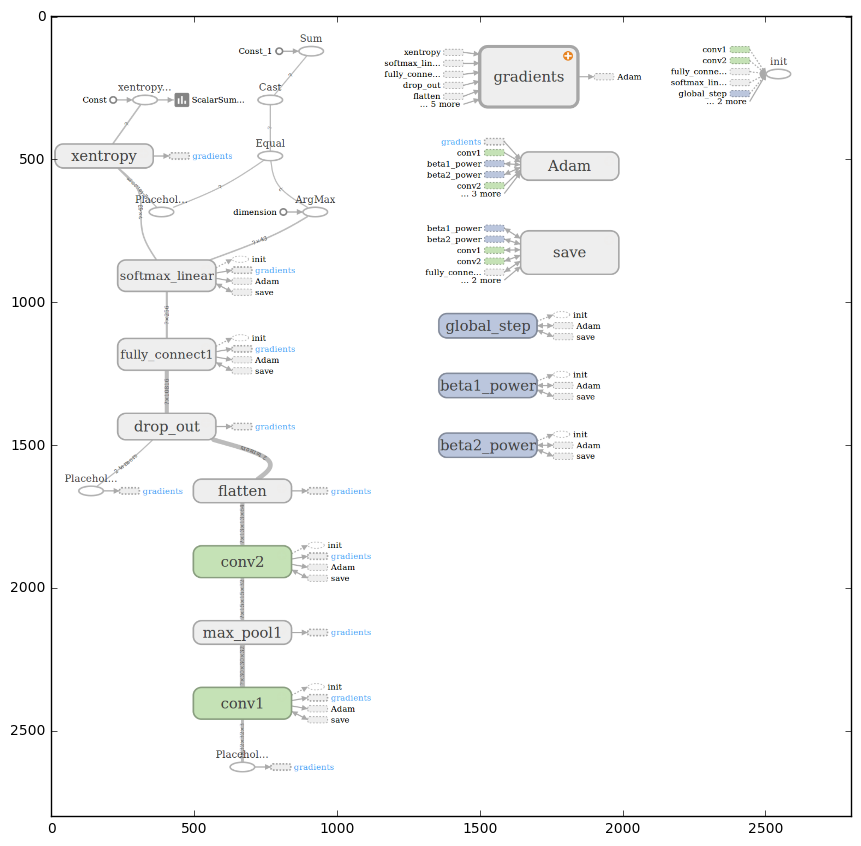

In [20]:
### show the model architecture

model = imread("./model_architecture.png")
fig= plt.figure(figsize=(10,10), dpi=100)
axes = fig.add_axes([0.1,0.1,0.8,0.8])

axes.imshow(np.uint8(imresize(model,(2800,2800))))
plt.show()


In [7]:
### the model is defined here.
def inference(features, conv1_out=32, conv2_out=64, fc1_out=256, keep_prob=1.0):
  """Build the model up to where it may be used for inference.

  Args:
    features: Images placeholder.
    conv1_out: Size of the first hidden layer.
    conv2_out: Size of the second hidden layer.
    fc1_out: Size of the fully connected layer.
    keep_prob: drop_out keep probability placeholder

  Returns:
    softmax_linear: Output tensor with the computed logits.
  """
  #30*30
  with tf.name_scope('conv1'):
    W_conv1 = _weight_variable([3, 3, 3, conv1_out], 'weights')
    b_conv1 = _bias_variable([conv1_out], 'biases')
    h_conv1 = tf.nn.relu(_conv2d(features, W_conv1) + b_conv1)

  #15*15
  with tf.name_scope('max_pool1'):
    h_pool1 = _max_pool_2x2(h_conv1)

  #13*13
  with tf.name_scope('conv2'):
    W_conv2 = _weight_variable([3, 3, conv1_out, conv2_out], 'weights')
    b_conv2 = _bias_variable([conv2_out], 'biases')
    h_conv2 = tf.nn.relu(_conv2d(h_pool1, W_conv2) + b_conv2)

  with tf.name_scope('flatten'):
    h_flatten = tf.reshape(h_conv2, [-1, 13*13*conv2_out])

  with tf.name_scope('drop_out'):
    h_drop = tf.nn.dropout(h_flatten, keep_prob)

  with tf.name_scope('fully_connect1'):
    W_fc1 = _weight_variable([13 * 13 * conv2_out, fc1_out], 'weights')
    b_fc1 = _bias_variable([fc1_out], 'biases')
    h_fc1 = tf.nn.relu(tf.matmul(h_drop, W_fc1) + b_fc1)

  with tf.name_scope('softmax_linear'):
    W_fc2 = _weight_variable([fc1_out, 43], 'weights')
    b_fc2 = _bias_variable([43], 'biases')
    logits = tf.matmul(h_fc1, W_fc2) + b_fc2

  return logits

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


### Question 5


_What approach did you take in coming up with a solution to this problem?_

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
def run_prediction():
  from scipy.misc import imread, imresize
  imgs = []
  fig, axes = plt.subplots(nrows=1,ncols=5)

  for i in range(5):
    path = './test_images/{0}.jpg'.format(i+1)
    img = imread(path)
    imgs.append(img)
    axes[i].imshow(img)
  plt.show()

  X = np.empty(shape=[5,32,32,3])
  for i in range(5):
    img = imresize(imgs[i], (32,32))
    img_normalized = img/255.0 -0.5
    X[i] = img_normalized

  features = tf.placeholder("float", [None, 32, 32, 3])
  keep_prob = tf.placeholder("float")
  # Build a Graph that computes predictions from the inference model.
  logits = cnn_helper.inference(features,conv1_out=32,conv2_out=64, fc1_out=256, keep_prob =keep_prob)
  probs = tf.nn.softmax(logits)
  top_k_op = tf.nn.top_k(probs, 5)

  saver = tf.train.Saver()
  path ="./log_model/model.ckpt"
  if os.path.exists("./log/model.ckpt.index"):
    path ="./log/model.ckpt"
  with tf.Session() as sess:
    saver.restore(sess, path)
    print("Model restored")
    values, indices = sess.run(top_k_op, feed_dict={features:X, keep_prob:1})

  import csv
  reader = csv.reader(open('signnames.csv', newline=''), delimiter=',')
  sign_map = {row[0]: row[1] for row in reader}

  for i in range(5):
    plt.figure(i)
    plt.imshow(np.uint8(imgs[i]))
    plt.show()
    probs = values[i]
    signs = indices[i]
    for k in range(probs.shape[0]):
      print("%.4f: %s" % (probs[k], sign_map[str(signs[k])]))

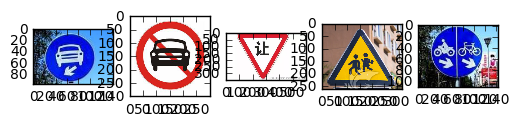

Model restored


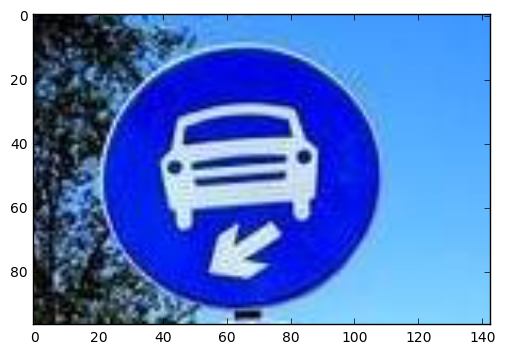

1.0000: Ahead only
0.0000: Speed limit (20km/h)
0.0000: Speed limit (30km/h)
0.0000: Speed limit (50km/h)
0.0000: Speed limit (60km/h)


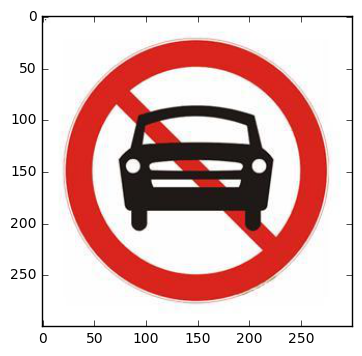

0.7081: No passing
0.2919: Vechiles over 3.5 metric tons prohibited
0.0000: Slippery road
0.0000: Speed limit (20km/h)
0.0000: Right-of-way at the next intersection


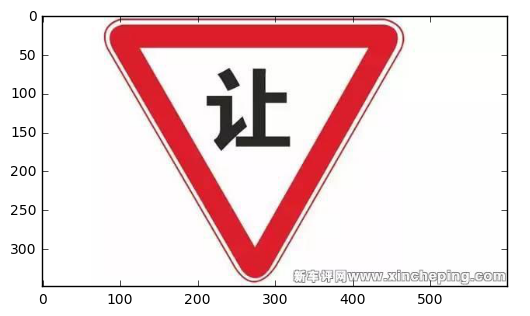

0.6075: Right-of-way at the next intersection
0.3886: Beware of ice/snow
0.0039: Yield
0.0000: General caution
0.0000: Double curve


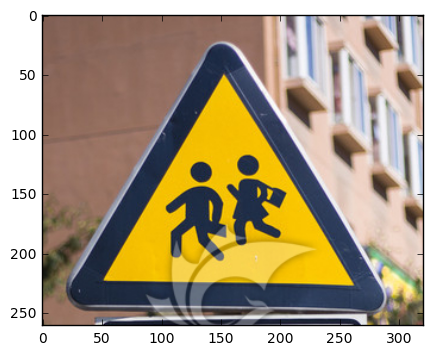

0.5971: Priority road
0.3898: Right-of-way at the next intersection
0.0130: Bicycles crossing
0.0000: Road work
0.0000: Dangerous curve to the right


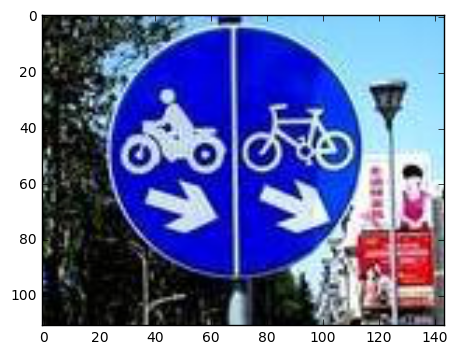

1.0000: Keep right
0.0000: Right-of-way at the next intersection
0.0000: Turn left ahead
0.0000: Roundabout mandatory
0.0000: Ahead only


In [4]:
#actually do prediction on new images
run_prediction()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

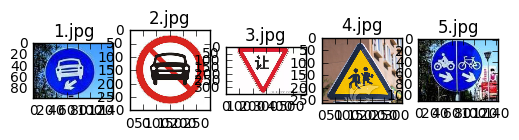

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
from scipy.misc import imread, imresize    
fig, axes = plt.subplots(nrows=1,ncols=5)  
for i in range(5):
    path = './test_images/{0}.jpg'.format(i+1) 
    img = imread(path)
    axes[i].imshow(img)
    axes[i].set_title('{0}.jpg'.format(i+1))
plt.show()  

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.